# Imports

In [108]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

# Loading the data

In [109]:
path = r"/Users/lenajd/Documents/python_work/Praktikum/Ex2/pictures/pictures"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
portraits = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.jpg'):
          # adds only the image files to the flowers list
            portraits.append(file.name)

The Model

In [110]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# feature extraction pipeline

In [111]:
# load the model first and pass as an argument
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

Now we can use this feature_extraction function to extract the features from all of the images and store the features in a dictionary with filename as the keys.

In [112]:
data = {}
p = r"/Users/lenajd/Documents/python_work/Praktikum/Ex2/pictures/portrait_features.pkl"

# lop through each image in the dataset
for portrait in portraits:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(portrait, model)
        data[portrait] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p, 'wb') as file:
            pickle.dump(data, file)

In [113]:
# get a list of the filenames
filenames = np.array(list(data.keys()))
# get a list of just the features
feat = np.array(list(data.values()))
feat = feat.reshape(-1, 4096)

# Dimensionality Reduction (PCA)

In [114]:
pca = PCA(random_state = 22)
pca.fit(feat)
x = pca.transform(feat)

# Cluster the images

In [115]:
kmeans = KMeans(n_clusters = 3, random_state = 22)
kmeans.fit(x)

KMeans(n_clusters=3, random_state=22)

In [116]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames, kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [117]:
# get information about clustering

pd.DataFrame(data = {'object': portraits, 'cluster_Nr.': kmeans.labels_})

,object,cluster_Nr.
0,smf_aug_xxx_03607_003.jpg,2
1,smf_aug_xxx_v-30-007-a_003.jpg,2
2,smf_aug_xxx_2019-100_002.jpg,2
3,smf_aug_xxx_2003-125_003.jpg,2
4,smf_aug_xxx_01573_003.jpg,1
5,smf_aug_xxx_2006-001_003.jpg,1
6,smf_aug_xxx_2019-035_001.jpg,2
7,smf_aug_xxx_2015-231_003.jpg,1
8,smf_aug_xxx_1999-513_003.jpg,2
9,smf_aug_xxx_1996-139_003.jpg,2


In [118]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25, 25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10, 10, index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

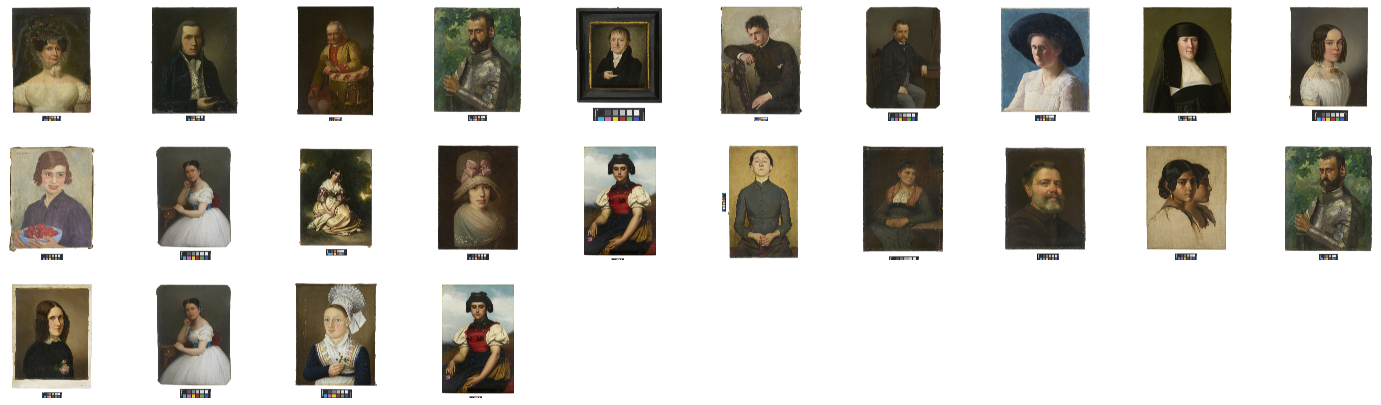

In [119]:
view_cluster(2)

# Prediction

In [120]:
path_pred = r"/Users/lenajd/Documents/python_work/Praktikum/Ex2/matching/matching"
os.chdir(path_pred)
matching = []
with os.scandir(path_pred) as files:
    for file in files:
        if file.name.endswith('.jpg'):
            matching.append(file.name)

In [121]:
data_pred = {}
p_pred = r"/Users/lenajd/Documents/python_work/Praktikum/Ex2/matching/match_features.pkl"

for match in matching:
    try:
        feat_new = extract_features(match, model)
        data_pred[match] = feat_new
    except:
        with open(p_pred, 'wb') as file:
            pickle.dump(data_pred, file)

In [122]:
feat_new = np.array(list(data_pred.values()))
feat_new = feat_new.reshape(-1, 4096)
feat_new.shape

(4, 4096)

In [123]:
pca = PCA(random_state = 22)
x_pca_new = pca.fit_transform(feat_new)

In [124]:
kmeans.fit_predict(x_pca_new)

array([0, 0, 1, 2], dtype=int32)

In [125]:
pd.DataFrame(data = {'match': matching, 'cluster_Nr.': kmeans.fit_predict(x_pca_new)})

,match,cluster_Nr.
0,WechatIMG1.jpg,0
1,WechatIMG3.jpg,0
2,WechatIMG2.jpg,1
3,smf_aug_xxx_v-56-002_005.jpg,2


# Choose a best parameter